In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_selection import SelectKBest, chi2
import json
import time


In [125]:
df = pkl.load(open('project8.pkl', 'rb'))
print(df.shape)
df.head()

(2027, 19)


,Unnamed: 0,post_id,self_text,user_is_verified,controversiality,ups,downs,subreddit,score,user_awardee_karma,user_awarder_karma,user_total_karma,user_comment_karma,user_link_karma,post_score,post_upvote_ratio,post_thumbs_up,post_total_awards_ratio,post_created_time
0,1979,9grgvl,"Yes, modeling anything with less resolution i...",True True True True True True True,0.142857,2.857143,0,climate_science,2.857143,8.571429,0.000000,11034.571429,10438.285714,587.714286,33,0.97,33,0,2018-09-18 03:59:40
1,503,1anritd,"Thing is, there's no official paper that desc...",True True True True True True True,0.000000,9.000000,0,climateskeptics,9.000000,748.142857,9.571429,91926.000000,42031.571429,49136.714286,67,0.94,67,0,2024-02-10 21:56:09
2,1387,16xyvqf,I read that article a month ago. Not sure wh...,True,0.000000,2.000000,0,climateskeptics,2.000000,315.000000,0.000000,37103.000000,36305.000000,483.000000,7,0.73,7,0,2023-10-02 14:58:12
3,918,18ii60q,&gt; Dr. Paul Pettré provides a damning critq...,True,0.000000,3.000000,0,climateskeptics,3.000000,1683.000000,20.000000,164653.000000,63989.000000,98961.000000,12,0.93,12,0,2023-12-14 20:42:33
4,1375,16zuc0a,This was a really good interview. She really ...,False,0.000000,3.000000,0,climateskeptics,3.000000,1703.000000,114.000000,1817.000000,0.000000,0.000000,27,0.97,27,0,2023-10-04 18:12:08


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2027 entries, 0 to 2026
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               2027 non-null   int64  
 1   post_id                  2027 non-null   object 
 2   self_text                2027 non-null   object 
 3   user_is_verified         2027 non-null   object 
 4   controversiality         2027 non-null   float64
 5   ups                      2027 non-null   float64
 6   downs                    2027 non-null   int64  
 7   subreddit                2027 non-null   object 
 8   score                    2027 non-null   float64
 9   user_awardee_karma       2022 non-null   float64
 10  user_awarder_karma       2022 non-null   float64
 11  user_total_karma         2022 non-null   float64
 12  user_comment_karma       2022 non-null   float64
 13  user_link_karma          2022 non-null   float64
 14  post_score              

### Task 1

In [127]:
df["preprocessed_text"] = df["self_text"].apply(lambda x: x.lower())

In [128]:
stop_words = set(stopwords.words('english'))
df["tokenized_text"] = df["preprocessed_text"].apply(lambda x: word_tokenize(x))
df["tokenized_text"] = df["tokenized_text"].apply(lambda x: [word for word in x if word not in stop_words])
df["tokenized_text"] = df["tokenized_text"].apply(lambda x: [word for word in x if word.isalnum()])
df["tokenized_text"] = df["tokenized_text"].apply(lambda x: [word for word in x if len(word) > 1]) # remove single character words, this can help with removing punctuation. 


In [129]:
#group by subreddit
grouped = df.groupby('subreddit')
df_cli_sci = grouped.get_group('climate_science')
df_cli_skp = grouped.get_group('climateskeptics')

print(df_cli_sci.shape)
print(df_cli_skp.shape)

(442, 21)
(1585, 21)


In [130]:
cli_sci_words = [word for words in df_cli_sci["tokenized_text"].values for word in words]
cli_skp_words = [word for words in df_cli_skp["tokenized_text"].values for word in words]

In [131]:
print(len(cli_sci_words))
print(len(cli_skp_words))

123994
487206


In [132]:
common_words = set()
with open ("common_words.txt", "r") as f:
    for line in f:
        common_words.add(line.strip())
        
print(len(common_words))

cli_sci_words = [word for word in cli_sci_words if word not in common_words]
cli_skp_words = [word for word in cli_skp_words if word not in common_words]

print(len(cli_sci_words))
print(len(cli_skp_words))


63
99671
393779


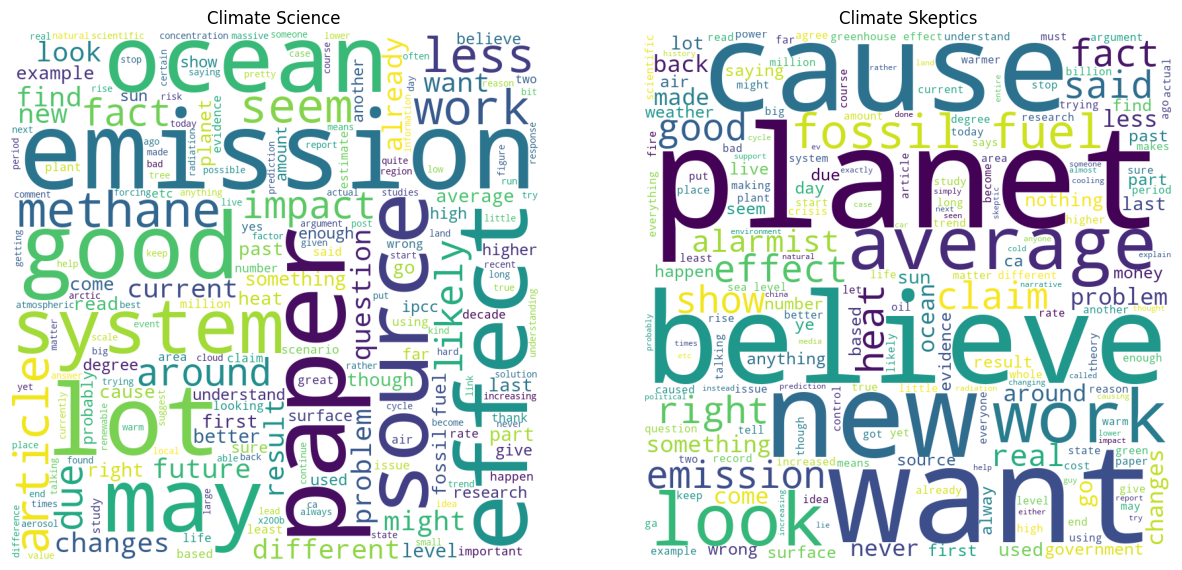

In [133]:
#word cloud for climate science and climate skeptics in subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

wordcloud_cli_sci = WordCloud(width=800, height=800, background_color='white').generate(' '.join(cli_sci_words))
ax[0].imshow(wordcloud_cli_sci)
ax[0].axis('off')
ax[0].set_title('Climate Science')

wordcloud_cli_skp = WordCloud(width=800, height=800, background_color='white').generate(' '.join(cli_skp_words))
ax[1].imshow(wordcloud_cli_skp)
ax[1].axis('off')
ax[1].set_title('Climate Skeptics')

plt.show()

In [134]:
from collections import Counter

total_cli_sci_words = len(cli_sci_words)
total_cli_skp_words = len(cli_skp_words)

cli_sci_word_freq = Counter({word: count / total_cli_sci_words for word, count in Counter(cli_sci_words).items()})
cli_skp_word_freq = Counter({word: count / total_cli_skp_words for word, count in Counter(cli_skp_words).items()})

print(cli_sci_word_freq.most_common(20))
print(cli_skp_word_freq.most_common(20))


[('emissions', 0.004013203439315348), ('methane', 0.0032807938116402964), ('good', 0.0028995394849053386), ('paper', 0.002367790029196055), ('lot', 0.002357757020597767), ('ocean', 0.00227749295181146), ('heat', 0.0022674599432131715), ('may', 0.0022574269346148828), ('effect', 0.0021871958744268645), ('less', 0.0021771628658285762), ('likely', 0.002116964814238846), ('ipcc', 0.0020968987970422692), ('since', 0.002066799771247404), ('might', 0.0020166347282559623), ('greenhouse', 0.001996568711059385), ('due', 0.0019765026938628086), ('already', 0.0019464036680679436), ('around', 0.0019464036680679436), ('different', 0.0019464036680679436), ('changes', 0.0019263376508713668)]
[('heat', 0.0031185004786949025), ('planet', 0.002897564369862283), ('effect', 0.0028163005137399402), ('gas', 0.002595364404907321), ('greenhouse', 0.0024074417376244036), ('since', 0.002211900583830016), ('oil', 0.0022042820973185466), ('weather', 0.002196663610807077), ('believe', 0.002171268655768845), ('new',

In [135]:
#after we have made a list of common words, we can remove them from the tokenized text
df["tokenized_text"] = df["tokenized_text"].apply(lambda x: [word for word in x if word not in common_words])
df["preprocessed_text"] = df["tokenized_text"].apply(lambda x: ' '.join(x)) # convert back to string, now each observation is a string of words that has been cleaned


### Task 2

In [136]:
 #initialize the vectorizer without any preprocessing
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df["preprocessed_text"]) #fitting and transforming the vectorizer on the preprocessed text 
tfidf_matrix = tfidf_matrix.toarray() #convert object matrix to a matrix
print(tfidf_matrix.shape) 

(2027, 30253)


In [137]:
df["tfidf_vector"] = [vector for vector in tfidf_matrix] #store the vectors in the dataframe for later use

In [138]:
most_prominent_words = ['emission', 'source', 'planet', 'believe']
#find the indices of the most prominent words in the tfidf features 
word_indices = [tfidf_vectorizer.vocabulary_[word] for word in most_prominent_words]
#find the cosine similarity between the most prominent words
cosine_similarities = cosine_similarity(tfidf_matrix[:, word_indices].T)
#store the cosine similarities in a dataframe
cosine_similarities_df = pd.DataFrame(cosine_similarities, columns=most_prominent_words, index=most_prominent_words)
print(cosine_similarities_df)

          emission    source    planet   believe
emission  1.000000  0.078340  0.090723  0.044319
source    0.078340  1.000000  0.119099  0.123720
planet    0.090723  0.119099  1.000000  0.232975
believe   0.044319  0.123720  0.232975  1.000000


### Task 3

In [180]:
# Traning a) Logistic Regression b) Random Forest c) Naive Bayes d) SVM  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import sklearn.preprocessing as preprocessing


X = tfidf_matrix
y = df["subreddit"].values
y = np.array([1 if subreddit == 'climate_science' else 0 for subreddit in y]) #convert the subreddit names to binary values
print(X.shape)
print(y.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


(2027, 30253)
(2027,)


In [140]:
def train_and_test(model, X_train, X_test, y_train, y_test):
    time_start = time.time()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred)
    
    time_elapsed = (time.time() - time_start)
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'time_elapsed(s)': time_elapsed}

In [141]:
classifiers = [
    ("Logistic Regression", LogisticRegression()), 
    ("Random Forest", RandomForestClassifier()), 
    ("Naive Bayes", MultinomialNB()), 
    ("SVM", SVC())
]
results = {}

for classifier in classifiers:
    name, model = classifier
    results[name] = train_and_test(model, X_train, X_test, y_train, y_test)

c:\Users\randy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [142]:
def print_results(results):
    print("----------------------------------------------")
    for name, result in results.items():
        print(f'{name}:')
        print(f'Accuracy: {result["accuracy"]}')
        print(f'Precision: {result["precision"]}')
        print(f'Recall: {result["recall"]}')
        print(f'F1: {result["f1"]}')
        print(f'Time Elapsed (s): {result["time_elapsed(s)"]}')
        print("----------------------------------------------")

In [143]:
print_results(results)

----------------------------------------------
Logistic Regression:
Accuracy: 0.8251231527093597
Precision: [0.81979695 1.        ]
Recall: [1.         0.14457831]
F1: [0.90097629 0.25263158]
Time Elapsed (s): 0.3078272342681885
----------------------------------------------
Random Forest:
Accuracy: 0.8103448275862069
Precision: [0.8075 1.    ]
Recall: [1.         0.07228916]
F1: [0.89349931 0.13483146]
Time Elapsed (s): 9.644683361053467
----------------------------------------------
Naive Bayes:
Accuracy: 0.7955665024630542
Precision: [0.7955665 0.       ]
Recall: [1. 0.]
F1: [0.8861454 0.       ]
Time Elapsed (s): 0.07558226585388184
----------------------------------------------
SVM:
Accuracy: 0.8300492610837439
Precision: [0.82397959 1.        ]
Recall: [1.        0.1686747]
F1: [0.9034965  0.28865979]
Time Elapsed (s): 43.31079888343811
----------------------------------------------


### Task 4

In [144]:
#function to prune the features
def select_k(k):
    selector = SelectKBest(chi2, k=k)
    selected_indices = selector.fit(X, y).get_support(indices=True) #get the indices of the selected features

    return selected_indices

In [145]:
pruned_results = {}

In [146]:
k_s = [25000, 20000, 15000, 10000, 5000]

for k in k_s:
    select_indices = select_k(k)
    X_train_k = X_train[:, select_indices]
    X_test_k = X_test[:, select_indices]
    pruned_results[f'RandomForest_{k}'] = train_and_test(RandomForestClassifier(), X_train_k, X_test_k, y_train, y_test)

In [147]:
print_results(pruned_results)

----------------------------------------------
RandomForest_25000:
Accuracy: 0.812807881773399
Precision: [0.80952381 1.        ]
Recall: [1.         0.08433735]
F1: [0.89473684 0.15555556]
Time Elapsed (s): 3.369384765625
----------------------------------------------
RandomForest_20000:
Accuracy: 0.8251231527093597
Precision: [0.81979695 1.        ]
Recall: [1.         0.14457831]
F1: [0.90097629 0.25263158]
Time Elapsed (s): 2.994028091430664
----------------------------------------------
RandomForest_15000:
Accuracy: 0.8226600985221675
Precision: [0.81933842 0.92307692]
Recall: [0.99690402 0.14457831]
F1: [0.89944134 0.25      ]
Time Elapsed (s): 2.5445139408111572
----------------------------------------------
RandomForest_10000:
Accuracy: 0.8349753694581281
Precision: [0.82820513 1.        ]
Recall: [1.         0.19277108]
F1: [0.90603086 0.32323232]
Time Elapsed (s): 2.0311696529388428
----------------------------------------------
RandomForest_5000:
Accuracy: 0.8201970443349754

In [148]:
#select top k features using tfidf
def select_k_tfidf(k):
    #sum the tfidf scores for each word
    word_scores = np.sum(tfidf_matrix, axis=0)
    #get the indices of the top k words
    top_k_indices = np.argsort(word_scores)[-k:] #sort the indices in ascending order and get the last k indices
     
    return top_k_indices

In [149]:
pruned_tfidf_results = {}

for k in k_s:
    select_indices = select_k_tfidf(k)
    X_train_k = X_train[:, select_indices]
    X_test_k = X_test[:, select_indices]
    pruned_tfidf_results[f'RandomForest_{k}'] = train_and_test(RandomForestClassifier(), X_train_k, X_test_k, y_train, y_test)
    
print_results(pruned_tfidf_results)

----------------------------------------------
RandomForest_25000:
Accuracy: 0.8103448275862069
Precision: [0.8075 1.    ]
Recall: [1.         0.07228916]
F1: [0.89349931 0.13483146]
Time Elapsed (s): 3.42771053314209
----------------------------------------------
RandomForest_20000:
Accuracy: 0.8103448275862069
Precision: [0.8075 1.    ]
Recall: [1.         0.07228916]
F1: [0.89349931 0.13483146]
Time Elapsed (s): 3.1001734733581543
----------------------------------------------
RandomForest_15000:
Accuracy: 0.8177339901477833
Precision: [0.81360202 1.        ]
Recall: [1.         0.10843373]
F1: [0.89722222 0.19565217]
Time Elapsed (s): 2.773667097091675
----------------------------------------------
RandomForest_10000:
Accuracy: 0.8275862068965517
Precision: [0.82188295 1.        ]
Recall: [1.         0.15662651]
F1: [0.90223464 0.27083333]
Time Elapsed (s): 2.3579463958740234
----------------------------------------------
RandomForest_5000:
Accuracy: 0.8226600985221675
Precision: [

### Task 5

In [150]:
df["post_created_time"] = pd.to_datetime(df["post_created_time"])
df['summer'] = df['post_created_time'].dt.month.isin([6, 7, 8]).astype(int)
df['winter'] = df['post_created_time'].dt.month.isin([12, 1, 2]).astype(int)
df['spring'] = df['post_created_time'].dt.month.isin([3, 4, 5]).astype(int)
df['fall'] = df['post_created_time'].dt.month.isin([9, 10, 11]).astype(int)

print(df[["post_created_time", 'summer', 'winter', 'spring', 'fall']].head())


    post_created_time  summer  winter  spring  fall
0 2018-09-18 03:59:40       0       0       0     1
1 2024-02-10 21:56:09       0       1       0     0
2 2023-10-02 14:58:12       0       0       0     1
3 2023-12-14 20:42:33       0       1       0     0
4 2023-10-04 18:12:08       0       0       0     1


In [195]:
#Add metadata features
optimal_k = 5000  
select_indices = select_k(optimal_k) #select the optimal k features
X_pruned = X[:, select_indices] #select the optimal k features from the original matrix
metadata_features = [   "score", 
                        "user_awardee_karma", 
                        "user_awarder_karma", 
                        "user_total_karma", 
                        "user_comment_karma", 
                        "user_link_karma",
                        "summer",
                        "fall",
                        "winter",
                        "spring",   
                     ]
metadata_matrix = df[metadata_features].values

# standardize the metadata features
metadata_matrix = preprocessing.MinMaxScaler().fit_transform(metadata_matrix) # the minmax is chosen because naive bayes assumes that the features are positive

print(metadata_matrix.shape)
#check if the metadata matrix contains any NaN values
print(np.isnan(metadata_matrix).any())

(2027, 10)
True


In [196]:
X_augmented = np.concatenate((X_pruned, metadata_matrix), axis=1) #concatenate the pruned features with the metadata features
print(X_augmented.shape)
rows_with_nan = np.isnan(X_augmented).any(axis=1) #check if there are any rows with NaN values
X_augmented = X_augmented[~rows_with_nan] #remove the rows with NaN values
y_augmented = y[~rows_with_nan] #remove the corresponding labels
print(X_augmented.shape)

(2027, 5010)
(2022, 5010)


In [197]:
X_train_augmented, X_test_augmented, y_train_augmented, y_test_augmented = train_test_split(X_augmented, y_augmented, test_size=0.2)

In [198]:
augmented_results = {}

for classifier in classifiers:
    name, model = classifier
    augmented_results[name] = train_and_test(model, X_train_augmented, X_test_augmented, y_train_augmented, y_test_augmented)
    
print_results(augmented_results)

----------------------------------------------
Logistic Regression:
Accuracy: 0.8444444444444444
Precision: [0.83289125 1.        ]
Recall: [1.         0.30769231]
F1: [0.90882779 0.47058824]
Time Elapsed (s): 0.10317420959472656
----------------------------------------------
Random Forest:
Accuracy: 0.8641975308641975
Precision: [0.85094851 1.        ]
Recall: [1.        0.3956044]
F1: [0.91947291 0.56692913]
Time Elapsed (s): 1.5987889766693115
----------------------------------------------
Naive Bayes:
Accuracy: 0.8345679012345679
Precision: [0.82414698 1.        ]
Recall: [1.         0.26373626]
F1: [0.90359712 0.4173913 ]
Time Elapsed (s): 0.014235734939575195
----------------------------------------------
SVM:
Accuracy: 0.8765432098765432
Precision: [0.86666667 0.95555556]
Recall: [0.99363057 0.47252747]
F1: [0.92581602 0.63235294]
Time Elapsed (s): 3.256107807159424
----------------------------------------------
